# Spaceship Titanic

The goal of this project is to build a model that predicts which passengers were transported from the Spaceship Titanic with the greatest possible accuracy.

## 1. Imports and EDA

In [1]:
import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

from xgboost import XGBClassifier

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
submission_df = pd.read_csv('test.csv')

In [4]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
train_df_len = len(train_df)
submission_df_len = len(submission_df)

In [7]:
def combine_df(train_df, submission_df):
    combined_df = pd.concat([train_df, submission_df], ignore_index=True)
    return combined_df

def separate_df(combined_df, train_df_len, submission_df_len):
    train_df = combined_df.iloc[:train_df_len]
    submission_df = combined_df.iloc[train_df_len:train_df_len + submission_df_len]
    return train_df, submission_df

full_df = combine_df(train_df, submission_df)
len(full_df)

12970

In [8]:
train_df['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

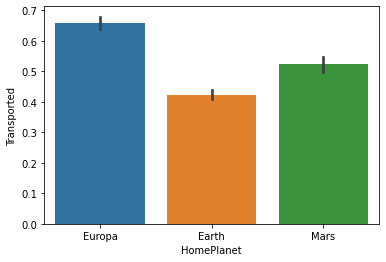

In [9]:
sns.barplot(x='HomePlanet',y='Transported',data=train_df);

In [10]:
train_df['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

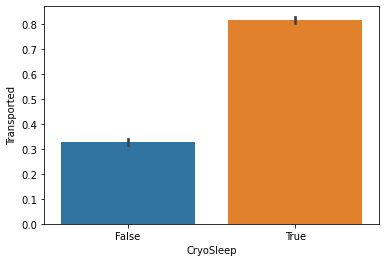

In [11]:
sns.barplot(x='CryoSleep',y='Transported',data=train_df);

In [12]:
full_df.loc[full_df['CryoSleep'] == True, ['RoomService','ShoppingMall','FoodCourt','Spa','VRDeck']] = full_df.loc[full_df['CryoSleep'] == True, ['RoomService','ShoppingMall','FoodCourt','Spa','VRDeck']].fillna(0)

In [13]:
cabin_counts = full_df['Cabin'].value_counts()

In [14]:
cabin_df = pd.DataFrame({'cabin' : cabin_counts.index, 'people in cabin' : cabin_counts.values})

In [15]:
cabin_df

,cabin,people in cabin
0,G/160/P,8
1,G/734/S,8
2,G/109/P,7
3,E/13/S,7
4,G/748/S,7
...,...,...
9820,F/1389/S,1
9821,G/1342/P,1
9822,G/702/P,1
9823,D/234/S,1


In [16]:
full_df = full_df.merge(cabin_df, left_on = 'Cabin', right_on = 'cabin', how = 'left')

In [17]:
full_df.drop('cabin',axis=1,inplace=True)

In [18]:
cabin_split = full_df['Cabin'].str.split('/', expand=True)
cabin_split.columns = ['Deck','Room_Number','Side']
full_df = pd.concat([full_df, cabin_split], axis = 1)
full_df.drop(columns=['Cabin'], inplace = True)
full_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,people in cabin,Deck,Room_Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1.0,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1.0,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,2.0,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2.0,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1.0,F,1,S


In [19]:
full_df['people in cabin'].value_counts()

1.0    8141
2.0    2066
3.0    1095
4.0     596
5.0     350
6.0     288
7.0     119
8.0      16
Name: people in cabin, dtype: int64

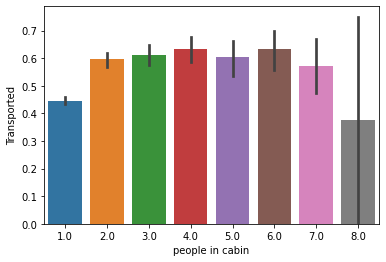

In [20]:
sns.barplot(x='people in cabin',y='Transported',data=full_df);

In [21]:
full_df.loc[full_df['people in cabin']==1,'Solo'] = 1
full_df.loc[full_df['people in cabin']!=1,'Solo'] = 0

In [22]:
full_df['Deck'].value_counts()

F    4239
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: Deck, dtype: int64

In [23]:
full_df['Room_Number'].value_counts()

82      34
4       28
56      28
230     27
95      27
        ..
1571     1
1835     1
1585     1
1857     1
1816     1
Name: Room_Number, Length: 1894, dtype: int64

In [24]:
full_df['Side'].value_counts()

S    6381
P    6290
Name: Side, dtype: int64

In [25]:
train_df['Destination'].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

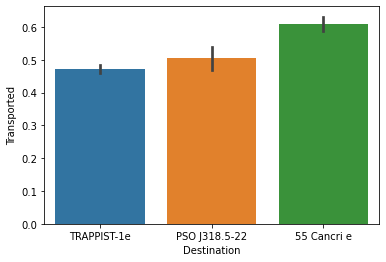

In [26]:
sns.barplot(x='Destination',y='Transported',data=train_df);

In [27]:
train_df['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

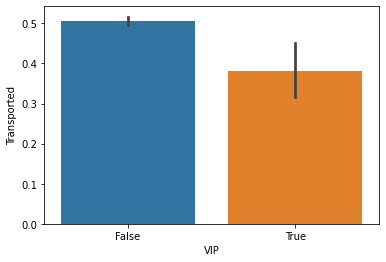

In [28]:
sns.barplot(x='VIP',y='Transported',data=train_df);

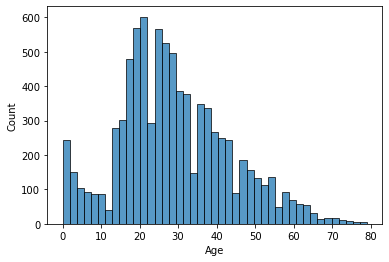

In [29]:
sns.histplot(x='Age',data=train_df);

In [30]:
train_df['Age_bins'] = pd.cut(train_df['Age'],bins=10)

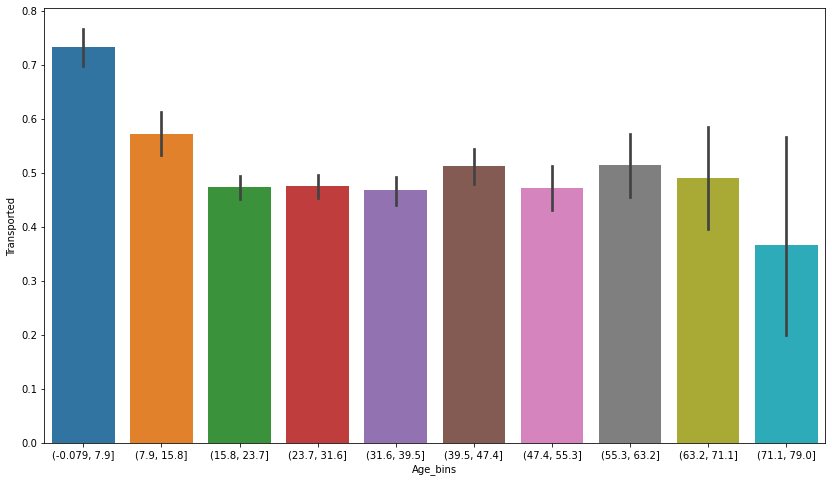

In [31]:
plt.figure(figsize=(14,8))
sns.barplot(x='Age_bins',y='Transported',data=train_df);

In [32]:
full_df.loc[full_df['Age']<8,'Child'] = 1
full_df.loc[full_df['Age']>=8,'Child'] = 0

In [33]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


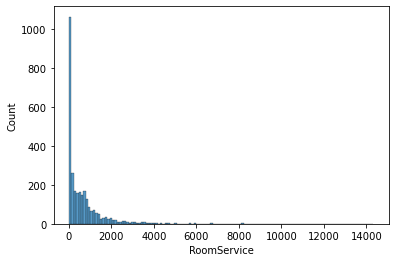

In [34]:
sns.histplot(x='RoomService',data=train_df[train_df['RoomService']!=0]);

In [35]:
full_df.loc[full_df['RoomService']==0,'RoomServiceSpending'] = 0
full_df.loc[full_df['RoomService']!=0,'RoomServiceSpending'] = 1

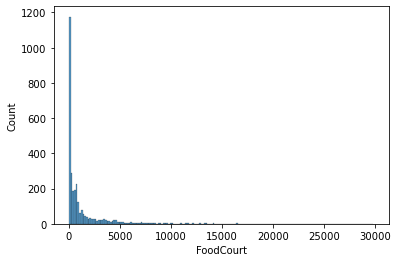

In [36]:
sns.histplot(x='FoodCourt',data=train_df[train_df['FoodCourt']!=0]);

In [37]:
full_df.loc[full_df['FoodCourt']==0,'FoodCourtSpending'] = 0
full_df.loc[full_df['FoodCourt']!=0,'FoodCourtSpending'] = 1

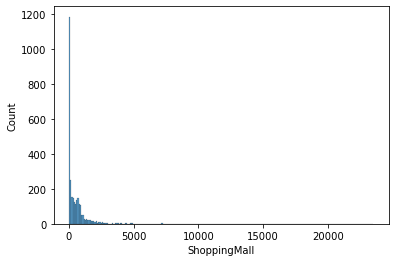

In [38]:
sns.histplot(x='ShoppingMall',data=train_df[train_df['ShoppingMall']!=0]);

In [39]:
full_df.loc[full_df['ShoppingMall']==0,'ShoppingMallSpending'] = 0
full_df.loc[full_df['ShoppingMall']!=0,'ShoppingMallSpending'] = 1

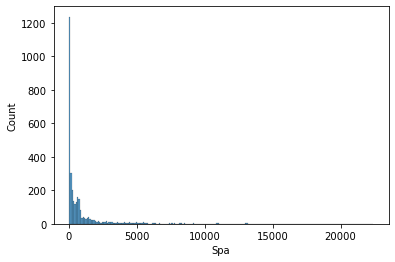

In [40]:
sns.histplot(x='Spa',data=train_df[train_df['Spa']!=0]);

In [41]:
full_df.loc[full_df['Spa'] == 0, 'SpaSpending'] = 0
full_df.loc[full_df['Spa'] != 0, 'SpaSpending'] = 1

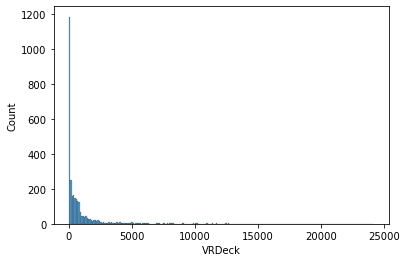

In [42]:
sns.histplot(x='VRDeck',data=train_df[train_df['VRDeck']!=0]);

In [43]:
full_df.loc[full_df['VRDeck'] == 0, 'VRSpending'] = 0
full_df.loc[full_df['VRDeck'] != 0, 'VRSpending'] = 1

In [44]:
full_df['Amenities'] = full_df['VRSpending'] + full_df['SpaSpending'] + full_df['ShoppingMallSpending'] + full_df['FoodCourtSpending'] + full_df['RoomServiceSpending']

In [45]:
full_df['Amenities'].value_counts()

0.0    5371
3.0    3040
4.0    2078
2.0    1659
5.0     445
1.0     377
Name: Amenities, dtype: int64

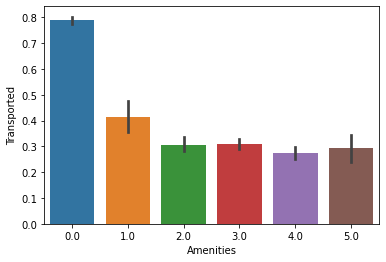

In [46]:
sns.barplot(x='Amenities',y='Transported',data=full_df);

In [47]:
full_df.loc[full_df['Amenities'] == 0, 'AmenityGroup'] = 0
full_df.loc[full_df['Amenities'] == 1, 'AmenityGroup'] = 1
full_df.loc[full_df['Amenities'] >= 2, 'AmenityGroup'] = 2

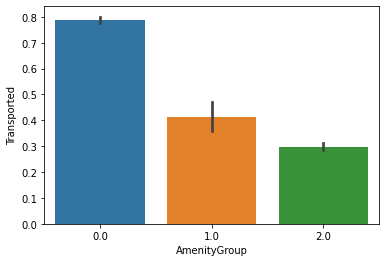

In [48]:
sns.barplot(x='AmenityGroup',y='Transported',data=full_df);

In [49]:
full_df.loc[full_df['Amenities']==0,'CryoSleep'] = full_df.loc[full_df['Amenities']==0,'CryoSleep'].fillna(True)
full_df.loc[full_df['Amenities']!=0,'CryoSleep'] = full_df.loc[full_df['Amenities']!=0,'CryoSleep'].fillna(False)

In [50]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 12969
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PassengerId           12970 non-null  object 
 1   HomePlanet            12682 non-null  object 
 2   CryoSleep             12970 non-null  object 
 3   Destination           12696 non-null  object 
 4   Age                   12700 non-null  float64
 5   VIP                   12674 non-null  object 
 6   RoomService           12800 non-null  float64
 7   FoodCourt             12790 non-null  float64
 8   ShoppingMall          12795 non-null  float64
 9   Spa                   12793 non-null  float64
 10  VRDeck                12793 non-null  float64
 11  Name                  12676 non-null  object 
 12  Transported           8693 non-null   object 
 13  people in cabin       12671 non-null  float64
 14  Deck                  12671 non-null  object 
 15  Room_Number        

In [51]:
full_df[['Solo','Child','AmenityGroup']] = full_df[['Solo','Child','AmenityGroup']].astype(object)

In [52]:
train_df, submission_df = separate_df(full_df, train_df_len, submission_df_len)

In [64]:
train_df['Transported'] = train_df['Transported'].astype(bool)

<ipython-input-64-11e9fc69bc87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Transported'] = train_df['Transported'].astype(bool)


## 2. Preparing for Modeling

In [65]:
X = train_df.drop('Transported',axis=1)
y = train_df['Transported']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = .2, random_state = 42)

In [67]:
ohecols = ['HomePlanet','CryoSleep','Destination','VIP','Deck','Side','AmenityGroup','Child','Solo']

In [68]:
numcols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [69]:
ohe_sub = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [70]:
num_sub = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [71]:
CT = ColumnTransformer(transformers=[
    ('ohe', ohe_sub, ohecols),
    ('num', num_sub, numcols),   
])

## 3. Modeling

### 3a. Dummy

In [72]:
dum_pipe = Pipeline([
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [73]:
dum_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'Side', 'AmenityGroup',
                                                   'Child', 'Solo']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('dummy', DummyClassifier(strategy='most_frequent'))])

In [74]:
dum_pipe.score(X_test,y_test)

0.5048878665899943

### 3b. Logistic Regression

In [75]:
lr_pipe = Pipeline([
    ('ct', CT),
    ('lr', LogisticRegression())
])

In [76]:
lr_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'Side', 'AmenityGroup',
                                                   'Child', 'Solo']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('lr', LogisticRegression())])

In [77]:
lr_pipe.score(X_test,y_test)

0.7855089131684876

### 3c. Random Forest

In [78]:
rf_pipe = Pipeline([
    ('ct', CT),
    ('rf', RandomForestClassifier(max_depth = 5))
])

In [79]:
rf_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'Side', 'AmenityGroup',
                                                   'Child', 'Solo']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('rf', RandomForestClassifier(max_depth=5))])

In [80]:
rf_pipe.score(X_test,y_test)

0.7561817136285222

### 3d. XGBoost

In [81]:
xgb_pipe = Pipeline([
    ('ct',CT),
    ('xgb',XGBClassifier(max_depth = 5))
])

In [82]:
xgb_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'Side', 'AmenityGroup',
                                                   'Child', 'Solo']),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [83]:
xgb_pipe.score(X_test,y_test)

0.7929844738355377

### 4. Submission

In [85]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4277 entries, 8693 to 12969
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PassengerId           4277 non-null   object 
 1   HomePlanet            4190 non-null   object 
 2   CryoSleep             4277 non-null   object 
 3   Destination           4185 non-null   object 
 4   Age                   4186 non-null   float64
 5   VIP                   4184 non-null   object 
 6   RoomService           4220 non-null   float64
 7   FoodCourt             4210 non-null   float64
 8   ShoppingMall          4214 non-null   float64
 9   Spa                   4218 non-null   float64
 10  VRDeck                4226 non-null   float64
 11  Name                  4183 non-null   object 
 12  Transported           0 non-null      object 
 13  people in cabin       4177 non-null   float64
 14  Deck                  4177 non-null   object 
 15  Room_Number      

In [86]:
passenger_ids = submission_df['PassengerId']

In [87]:
predictions = xgb_pipe.predict(submission_df).astype(bool)

In [88]:
result_df = pd.DataFrame({'PassengerId':passenger_ids,'Transported':predictions})

In [90]:
result_df.to_csv('submission_2.csv',index=False)